# Swiss Energy Storage Portfolio Optimization

**Objective:** Find an optimal mix of Power Production Units (PPUs) that can satisfy Switzerland's 113 TWh annual energy demand while minimizing costs.

**Key Features:**
- Energy sovereignty constraint (annual production ≥ 113 TWh)
- Multi-scenario robustness evaluation
- Sophisticated dispatch simulation with storage management
- Genetic Algorithm optimization with plateau detection

---

## Table of Contents

1. [Configuration & Hyperparameters](#config)
2. [Data Loading](#data)
3. [PPU Framework Overview](#ppu)
4. [Dispatch Logic Overview](#dispatch)
5. [Run Optimization](#optimization)
6. [Results & Analysis](#results)
7. [Visualization](#visualization)


In [1]:
# ============================================================================
# ALL IMPORTS - Consolidated in first cell to ensure fresh module loading
# ============================================================================

# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
import os
import json
import pickle
import importlib
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings('ignore')

# Reload modules to pick up any code changes
import config, data_loader, ppu_framework, dispatch_engine, optimization, visualization
import risk_calculator, portfolio_metrics, portfolio_explorer
import pareto_frontier, multi_objective_explorer

# Reload all modules to ensure we're using the latest code
for mod in [config, data_loader, ppu_framework, dispatch_engine, optimization, visualization,
            risk_calculator, portfolio_metrics, portfolio_explorer, pareto_frontier, multi_objective_explorer]:
    importlib.reload(mod)

# Project imports - Core modules
from config import Config, DEFAULT_CONFIG
from data_loader import load_all_data, validate_data, get_annual_statistics, clear_cache
clear_cache()  # Clear any stale data cache

from ppu_framework import (
    load_all_ppu_data, Portfolio, create_ppu_dictionary,
    assign_renewable_locations, estimate_annual_production, check_energy_sovereignty
)

from dispatch_engine import (
    run_dispatch_simulation, compute_scenario_cost, calculate_disposition_index
)

from optimization import (
    run_genetic_algorithm, load_optimization_results, portfolio_summary,
    evaluate_portfolio_full_year, FullYearResults
)

from visualization import (
    plot_fitness_evolution, plot_portfolio_composition,
    plot_dispatch_scenario, create_optimization_dashboard,
    plot_demand_volatility, plot_spot_price_volatility, plot_spot_price_distribution,
    calculate_hourly_production_cost, plot_price_comparison_volatility, plot_price_comparison_distribution,
    plot_ppu_cost_breakdown, plot_portfolio_cost_breakdown, plot_energy_balance_distribution,
    plot_full_year_production_by_source, plot_full_year_production_by_ppu,
    plot_full_year_overview, plot_full_year_storage, plot_individual_storage
)

# 3D Metrics and Risk Analysis
from portfolio_metrics import PortfolioMetrics3D, calculate_portfolio_metrics_3d
from risk_calculator import RiskCalculator
from portfolio_explorer import explore_portfolio_space

# Pareto Frontier Analysis
from pareto_frontier import (
    find_and_plot_efficiency_frontier,
    load_frontier_from_csv,
    plot_efficiency_frontier,
    print_frontier_summary
)

# Multi-Objective Exploration
from multi_objective_explorer import (
    explore_and_find_frontier,
    continue_exploration_3d_frontier,
    MultiObjectiveGA,
    get_objective_configs
)

print("✅ All modules imported successfully!")
print("   - Core modules: config, data_loader, ppu_framework, dispatch_engine, optimization, visualization")
print("   - 3D metrics: risk_calculator, portfolio_metrics, portfolio_explorer")
print("   - Analysis: pareto_frontier, multi_objective_explorer")
print("   - All modules reloaded to ensure latest code versions")


✅ All modules imported successfully!
   - Core modules: config, data_loader, ppu_framework, dispatch_engine, optimization, visualization
   - 3D metrics: risk_calculator, portfolio_metrics, portfolio_explorer
   - Analysis: pareto_frontier, multi_objective_explorer
   - All modules reloaded to ensure latest code versions


<a id="config"></a>
## 1. Configuration & Hyperparameters

All tunable parameters are centralized here. Modify this cell to experiment with different settings.


In [2]:
# ============================================================================
# HYPERPARAMETERS - Modify these values to tune the optimization
# ============================================================================

# Create configuration object
config = Config()

# --- RUN MODE ---
# Options: "quick" (~1 hour), "overnight" (~8 hours), "custom"
config.run_mode.MODE = "quick"

# Custom mode settings (only used if MODE = "custom")
config.run_mode.CUSTOM_POP_SIZE = 100
config.run_mode.CUSTOM_N_GENERATIONS = 60
config.run_mode.CUSTOM_PLATEAU_GENERATIONS = 7

# --- ENERGY TARGET ---
# Switzerland's 2050 target: 113 TWh/year
config.energy_system.TARGET_ANNUAL_DEMAND_TWH = 65.0

# --- SCENARIO SETTINGS ---
# Number of random days to sample per scenario
config.scenario.DAYS_PER_SCENARIO = 30

# Number of scenarios to run per portfolio evaluation
config.scenario.SCENARIOS_PER_EVALUATION = 3

# --- GENETIC ALGORITHM ---
config.ga.CROSSOVER_RATE = 0.8      # Probability of crossover
config.ga.MUTATION_RATE = 0.2       # Probability of mutation per gene
config.ga.MUTATION_SIGMA = 0.1      # Gaussian mutation std dev (relative)
config.ga.ELITE_FRACTION = 0.1      # Top 10% survive unchanged
config.ga.TOURNAMENT_SIZE = 3       # Tournament selection size
config.ga.RANDOM_SEED = 42          # For reproducibility (None for random)

# --- STORAGE SETTINGS ---
config.storage.INITIAL_SOC_FRACTION = 0.10  # Initial State of Charge (10%)
config.storage.TARGET_SOC_FRACTION = 0.60   # Target SoC

# --- FITNESS FUNCTION ---
# Penalty multiplier for portfolios that don't meet energy sovereignty
config.fitness.SOVEREIGNTY_PENALTY_MULTIPLIER = 1e6

# CVaR weight (tail risk vs mean cost trade-off)
config.fitness.CVAR_WEIGHT = 0.3  # 30% weight on worst-case scenarios

# --- SPOT PRICE THRESHOLDS (for dispatch decisions) ---
config.dispatch.SPOT_PRICE_LOW_THRESHOLD = 30.0   # CHF/MWh - charge below this
config.dispatch.SPOT_PRICE_HIGH_THRESHOLD = 80.0  # CHF/MWh - discharge above this

# --- IMPORT PRICES FOR STORAGE ---
# These are set in the storage definitions (config.py)
# Biooil: 67 CHF/MWh
# Palm oil: 87 CHF/MWh

# Print configuration summary
print(config.summary())


CONFIGURATION SUMMARY
Run Mode: quick
  - Population Size: 25
  - Generations: 5
  - Plateau Detection: 3 generations

Energy Target: 65.0 TWh/year

Scenario Settings:
  - Days per scenario: 30
  - Scenarios per evaluation: 3
  - Total timesteps: 720

GA Parameters:
  - Crossover Rate: 0.8
  - Mutation Rate: 0.2
  - Elite Fraction: 0.1

Storage Initial SoC: 10.0%



<a id="data"></a>
## 2. Data Loading

Load all required data files and validate them.


In [3]:
# Load all data (force_reload=True to clear any stale cache)
data = load_all_data(config, force_reload=True)

# Validate data consistency
validate_data(data)

# Print annual statistics
stats = get_annual_statistics(data)
print("\n📊 Annual Statistics (2024 data):")
print(f"   Total demand: {stats['total_demand_twh']:.2f} TWh")
print(f"   Peak demand:  {stats['peak_demand_mw']:,.0f} MW")
print(f"   Avg demand:   {stats['avg_demand_mw']:,.0f} MW")
print(f"   Avg spot:     {stats['avg_spot_price']:.2f} CHF/MWh")
print(f"   Max spot:     {stats['max_spot_price']:.2f} CHF/MWh")
print(f"   Min spot:     {stats['min_spot_price']:.2f} CHF/MWh")


Loading data files...
  - Solar incidence: (9072, 1150)
  - Wind incidence: (9072, 1150)
  - Spot prices: (8784,)
  - Demand: (8784,)
  - Hydro data loaded
  - Cost data loaded
  - Aligned all data to 8784 timesteps (366 days)
Data loading complete!
Data validation passed!

📊 Annual Statistics (2024 data):
   Total demand: 59.63 TWh
   Peak demand:  10,437 MW
   Avg demand:   6,788 MW
   Avg spot:     75.96 CHF/MWh
   Max spot:     310.64 CHF/MWh
   Min spot:     -427.51 CHF/MWh


In [4]:
# Load PPU definitions
cost_df, constructs_df, ppu_definitions = load_all_ppu_data(config)

print(f"Loaded {len(cost_df)} cost components")
print(f"Loaded {len(constructs_df)} PPU constructs")
print(f"Built {len(ppu_definitions)} PPU definitions")

# Display PPU summary
print("\n📋 PPU Summary:")
print("-" * 70)
for name, ppu_def in sorted(ppu_definitions.items()):
    print(f"  {name:15s} | {ppu_def.category:12s} | η={ppu_def.efficiency:.3f} | "
          f"Cost={ppu_def.cost_per_mwh:.2f} CHF/MWh")


Loaded 83 cost components
Loaded 26 PPU constructs
Built 26 PPU definitions

📋 PPU Summary:
----------------------------------------------------------------------
  BIO_OIL_ICE     | Production   | η=0.282 | Cost=0.10 CHF/MWh
  BIO_WOOD        | Production   | η=0.399 | Cost=0.22 CHF/MWh
  CH4_BIO         | Storage      | η=0.445 | Cost=0.11 CHF/MWh
  H2P_G           | Production   | η=0.475 | Cost=0.10 CHF/MWh
  H2P_L           | Production   | η=0.475 | Cost=0.03 CHF/MWh
  H2_G            | Storage      | η=0.582 | Cost=0.16 CHF/MWh
  H2_GL           | Storage      | η=0.501 | Cost=0.16 CHF/MWh
  H2_L            | Storage      | η=0.600 | Cost=0.08 CHF/MWh
  HYD_R           | Production   | η=0.880 | Cost=0.04 CHF/MWh
  HYD_S           | Production   | η=0.880 | Cost=0.04 CHF/MWh
  IMP_BIOG        | Production   | η=0.485 | Cost=0.04 CHF/MWh
  NH3_FULL        | Storage      | η=0.465 | Cost=0.10 CHF/MWh
  NH3_P           | Production   | η=0.356 | Cost=0.11 CHF/MWh
  PALM_ICE        

In [5]:
# =============================================================================
# RESTORE SAVED OPTIMIZATION RESULTS (if available)
# =============================================================================
# Run this cell after restarting VS Code to restore your saved optimization results
# This will load best_individual, ga_stats, and config from the saved pickle file

# Check for saved results
results_file = Path('ga_optimization_results.pkl')
alternative_file = Path('ga_optimization_results_pop15_gen10.pkl')

if results_file.exists():
    print("✅ Found saved optimization results!")
    print(f"   Loading from: {results_file}")
    print()
    
    # Load the results
    best_individual, ga_stats, saved_config = load_optimization_results(str(results_file))
    
    # Optionally update config (comment out if you want to use current config)
    # config = saved_config
    
    print("📊 Loaded Results Summary:")
    print(f"   Fitness:         {best_individual.fitness:,.0f} CHF")
    print(f"   Annual prod:     {best_individual.annual_production_twh:.1f} TWh/year")
    print(f"   Sovereign:       {'✅ Yes' if best_individual.is_sovereign else '❌ No'}")
    print(f"   Mean cost:       {best_individual.mean_cost:,.0f} CHF")
    print(f"   CVaR (95%):      {best_individual.cvar:,.0f} CHF")
    print(f"   Generations:     {ga_stats.generation}")
    print(f"   Total time:      {ga_stats.elapsed_time_s:.1f}s ({ga_stats.elapsed_time_s/60:.1f} min)")
    print()
    print("✅ Variables restored: best_individual, ga_stats")
    print("   You can now run the analysis cells below without re-running the optimization.")
    
elif alternative_file.exists():
    print("✅ Found alternative saved optimization results!")
    print(f"   Loading from: {alternative_file}")
    print()
    
    best_individual, ga_stats, saved_config = load_optimization_results(str(alternative_file))
    
    print("📊 Loaded Results Summary:")
    print(f"   Fitness:         {best_individual.fitness:,.0f} CHF")
    print(f"   Annual prod:     {best_individual.annual_production_twh:.1f} TWh/year")
    print(f"   Sovereign:       {'✅ Yes' if best_individual.is_sovereign else '❌ No'}")
    print(f"   Mean cost:       {best_individual.mean_cost:,.0f} CHF")
    print(f"   CVaR (95%):      {best_individual.cvar:,.0f} CHF")
    print(f"   Generations:     {ga_stats.generation}")
    print(f"   Total time:      {ga_stats.elapsed_time_s:.1f}s ({ga_stats.elapsed_time_s/60:.1f} min)")
    print()
    print("✅ Variables restored: best_individual, ga_stats")
    
else:
    print("⚠️  No saved optimization results found.")
    print("   Available files:")
    for pkl_file in Path('.').glob('*.pkl'):
        print(f"      - {pkl_file}")
    print()
    print("   You need to run the optimization cell below to generate results.")
    print("   Or if you have results in a different file, modify 'results_file' above.")


✅ Found saved optimization results!
   Loading from: ga_optimization_results.pkl

📊 Loaded Results Summary:
   Fitness:         6,181,330 CHF
   Annual prod:     114.0 TWh/year
   Sovereign:       ✅ Yes
   Mean cost:       6,181,330 CHF
   CVaR (95%):      0 CHF
   Generations:     5
   Total time:      580.6s (9.7 min)

✅ Variables restored: best_individual, ga_stats
   You can now run the analysis cells below without re-running the optimization.


In [6]:
# Display storage systems
print("\n🔋 Storage Systems:")
print("-" * 80)
for name, storage_def in config.storage.STORAGE_DEFINITIONS.items():
    cap_twh = storage_def['capacity_MWh'] / 1e6
    power_gw = storage_def['max_power_MW'] / 1e3
    eff = storage_def['efficiency_discharge']
    
    print(f"  {name:18s} | Capacity: {cap_twh:8.3f} TWh | "
          f"Power: {power_gw:6.2f} GW | η_dis: {eff:.2f}")


🔋 Storage Systems:
--------------------------------------------------------------------------------
  Lake               | Capacity:    8.870 TWh | Power:   2.00 GW | η_dis: 0.88
  Fuel Tank          | Capacity:   20.000 TWh | Power:  50.00 GW | η_dis: 0.50
  H2 UG 200bar       | Capacity:    0.700 TWh | Power:   5.00 GW | η_dis: 0.50
  Liquid H2          | Capacity:    0.100 TWh | Power:   2.00 GW | η_dis: 0.50
  Solar salt         | Capacity:    0.050 TWh | Power:   1.00 GW | η_dis: 0.90
  Biooil             | Capacity:    0.500 TWh | Power:   5.00 GW | η_dis: 0.30
  Palm oil           | Capacity:    0.500 TWh | Power:   5.00 GW | η_dis: 0.30
  Biogas             | Capacity:    0.200 TWh | Power:   2.00 GW | η_dis: 0.50
  CH4 200bar         | Capacity:    0.700 TWh | Power:   5.00 GW | η_dis: 0.50
  Ammonia            | Capacity:    0.300 TWh | Power:   3.00 GW | η_dis: 0.38


<a id="dispatch"></a>
## 4. Dispatch Logic Overview

The dispatch simulation determines how energy flows between production, storage, and demand at each timestep.

### Key Concepts:

1. **Net System Balance:** $\Phi_t = D_t - S_t^{\text{renew}}$
   - $\Phi_t > 0$: Deficit (need to discharge storage or buy from spot)
   - $\Phi_t < 0$: Surplus (can charge storage or sell to spot)

2. **Disposition Index:** $d_{\text{stor}} = \tanh\left(\frac{\text{SoC} - \text{SoC}^*}{\text{deadband}}\right)$
   - Positive: Storage prefers to discharge
   - Negative: Storage prefers to charge

3. **Utility Index:** $u_{\text{dis}} = \tanh\left(\frac{\bar{\Phi}}{\alpha_u}\right)$
   - Higher during system deficit
   - Encourages discharge when system needs energy


In [7]:
# Demo: Show disposition index behavior
print("📈 Disposition Index vs State of Charge:")
print("-" * 50)
for soc in [0.10, 0.30, 0.50, 0.60, 0.70, 0.90]:
    d_stor = calculate_disposition_index(soc, soc_target=0.60)
    action = "Charge" if d_stor < -0.3 else ("Discharge" if d_stor > 0.3 else "Neutral")
    print(f"  SoC = {soc*100:5.1f}% → d_stor = {d_stor:+.3f} → {action}")


📈 Disposition Index vs State of Charge:
--------------------------------------------------
  SoC =  10.0% → d_stor = -0.674 → Charge
  SoC =  30.0% → d_stor = -0.426 → Charge
  SoC =  50.0% → d_stor = -0.091 → Neutral
  SoC =  60.0% → d_stor = +0.000 → Neutral
  SoC =  70.0% → d_stor = +0.091 → Neutral
  SoC =  90.0% → d_stor = +0.426 → Discharge


<a id="optimization"></a>
## 5. Run Optimization

Run the Genetic Algorithm to find the optimal portfolio.


In [ ]:
# Run the genetic algorithm
# This is the main optimization - may take 1+ hour depending on settings

best_individual, ga_stats = run_genetic_algorithm(
    config=config,
    verbose=True,
    save_progress=True
)


<a id="results"></a>
## 6. Results & Analysis


In [ ]:
# Display final results
print("=" * 70)
print("OPTIMIZATION RESULTS")
print("=" * 70)

print(f"\n⏱️  Total time: {ga_stats.elapsed_time_s:.1f} seconds ({ga_stats.elapsed_time_s/60:.1f} minutes)")
print(f"🧬 Generations: {ga_stats.generation}")
print(f"📊 Total evaluations: {ga_stats.total_evaluations}")

print(f"\n🏆 BEST PORTFOLIO:")
print(f"   Fitness:         {best_individual.fitness:,.0f} CHF")
print(f"   Annual prod:     {best_individual.annual_production_twh:.1f} TWh/year")
print(f"   Sovereign:       {'✅ Yes' if best_individual.is_sovereign else '❌ No'}")
print(f"   Mean cost:       {best_individual.mean_cost:,.0f} CHF")
print(f"   CVaR (95%):      {best_individual.cvar:,.0f} CHF")


In [ ]:
# Display portfolio composition
portfolio_df = portfolio_summary(best_individual)
portfolio_df = portfolio_df.sort_values('Count', ascending=False)

print("\n📦 Portfolio Composition:")
print("-" * 40)
display(portfolio_df)

print(f"\n   Total PPU units: {portfolio_df['Count'].sum()}")


<a id="visualization"></a>
## 7. Visualization


In [ ]:
# Plot fitness evolution
fig = plot_fitness_evolution(
    ga_stats.best_fitness_history,
    ga_stats.mean_fitness_history,
    title="GA Fitness Evolution",
    save_path="data/result_plots/fitness_evolution.png"
)
plt.show()


In [ ]:
# Plot portfolio composition
fig = plot_portfolio_composition(
    best_individual.portfolio.ppu_counts,
    title="Optimal Portfolio Composition",
    save_path="data/result_plots/portfolio_composition.png"
)
plt.show()


In [ ]:
# Create comprehensive dashboard
final_metrics = {
    'annual_production_twh': best_individual.annual_production_twh,
    'mean_cost': best_individual.mean_cost,
    'cvar': best_individual.cvar,
    'is_sovereign': best_individual.is_sovereign,
}

fig = create_optimization_dashboard(
    ga_stats.best_fitness_history,
    best_individual.portfolio.ppu_counts,
    final_metrics,
    title="Swiss Energy Portfolio Optimization - Results Dashboard",
    save_path="data/result_plots/optimization_dashboard.png"
)
plt.show()


In [ ]:
# Save final results to CSV for reporting
os.makedirs('data/result_plots', exist_ok=True)

portfolio_df.to_csv('data/result_plots/optimal_portfolio.csv', index=False)

# Save key metrics
metrics_df = pd.DataFrame([{
    'Metric': 'Final Fitness',
    'Value': f"{best_individual.fitness:,.0f} CHF"
}, {
    'Metric': 'Annual Production',
    'Value': f"{best_individual.annual_production_twh:.1f} TWh/year"
}, {
    'Metric': 'Energy Sovereign',
    'Value': 'Yes' if best_individual.is_sovereign else 'No'
}, {
    'Metric': 'Mean Scenario Cost',
    'Value': f"{best_individual.mean_cost:,.0f} CHF"
}, {
    'Metric': 'CVaR (95%)',
    'Value': f"{best_individual.cvar:,.0f} CHF"
}, {
    'Metric': 'Generations',
    'Value': str(ga_stats.generation)
}, {
    'Metric': 'Optimization Time',
    'Value': f"{ga_stats.elapsed_time_s/60:.1f} minutes"
}])

metrics_df.to_csv('data/result_plots/optimization_metrics.csv', index=False)

print("\n✅ Results saved to data/result_plots/")
print("   - optimal_portfolio.csv")
print("   - optimization_metrics.csv")
print("   - fitness_evolution.png")
print("   - portfolio_composition.png")
print("   - optimization_dashboard.png")



## Full year

Now we test the optimized portfolio across the **entire year** 
(not random scenarios) to validate its robustness and real-world performance.


In [ ]:
# Run full year evaluation on the best portfolio
full_year_results = evaluate_portfolio_full_year(
    best_individual,
    config,
    verbose=True
)


In [ ]:
# Full year overview plot
fig = plot_full_year_overview(
    full_year_results,
    title="Full Year Evaluation - Portfolio Performance",
    save_path="data/result_plots/full_year_overview.png"
)
plt.show()


In [ ]:
# 1. Production by Source (Stacked Area)
# This will now show the REAL curves (no more horizontal lines)
# and Solar will correctly drop to zero at night.
fig1 = plot_full_year_production_by_source(
    full_year_results,
    title="Swiss Energy Portfolio: Hourly Production Stack vs Demand",
    save_path="data/result_plots/full_year_production_by_source.png"
)
plt.show()

# 2. Production Decomposed by PPU Origin
# Shows which type of PPU produces when across the year
fig2 = plot_full_year_production_by_ppu(
    full_year_results,
    title="Swiss Energy Portfolio: Production Decomposed by PPU Origin",
    save_path="data/result_plots/full_year_production_by_ppu.png"
)
plt.show()

# 3. Energy Balance Analysis (Portfolio Performance)
# This is the "Truth" plot that shows your surplus and deficits.
# Since we fixed the 'capping' bug, you will now see huge green spikes 
# during the day when Solar > Demand.
fig3 = plot_energy_balance_distribution(
    demand=full_year_results.demand,
    production=full_year_results.total_production,
    renewable_production=full_year_results.renewable_production,
    spot_bought=full_year_results.spot_bought,
    spot_sold=full_year_results.spot_sold,
    include_spot_in_balance=False, # Set to False to see the PORTFOLIO balance
    title="Portfolio Energy Balance (Surplus/Deficit before Spot Market)",
    save_path="data/result_plots/energy_balance_distribution.png"
)
plt.show()

In [ ]:
# Storage state of charge over the year
fig = plot_full_year_storage(
    full_year_results,
    title="Storage State of Charge - Full Year",
    save_path="data/result_plots/full_year_storage.png"
)
plt.show()

# Save individual storage plots
plot_individual_storage(
    full_year_results,
    save_folder="data/result_plots/scenario_evolution"
)


In [ ]:
# Energy Balance Distribution - Surplus vs Deficit Analysis
print("=" * 60)
print("ENERGY BALANCE DISTRIBUTION")
print("=" * 60)
print()
print("Analyzing when we have energy surplus vs deficit over the year...")
print()

# Create energy balance distribution plot
fig = plot_energy_balance_distribution(
    demand=full_year_results.demand,
    production=full_year_results.total_production,
    title="Energy Balance Distribution - Full Year 2024",
    save_path="data/result_plots/energy_balance_distribution.png"
)
plt.show()

print("\n✅ Energy balance distribution plot saved to data/result_plots/energy_balance_distribution.png")


In [ ]:
# Summary comparison: Random scenarios vs Full Year
print("=" * 60)
print("COMPARISON: Optimization vs Full Year Validation")
print("=" * 60)
print()
print("During Optimization (Random Scenarios):")
print(f"  Annual Production: {best_individual.annual_production_twh:.1f} TWh/year")
print(f"  Mean Scenario Cost: {best_individual.mean_cost:,.0f} CHF")
print(f"  CVaR (95%): {best_individual.cvar:,.0f} CHF")
print()
print("Full Year Validation:")
print(f"  Total Production: {full_year_results.total_production_twh:.1f} TWh")
print(f"  Total Demand: {full_year_results.total_demand_twh:.1f} TWh")
print(f"  Coverage Ratio: {full_year_results.coverage_ratio*100:.1f}%")
print(f"  Net Spot Cost: {full_year_results.total_spot_cost_chf/1e6:.1f} M CHF")
print(f"  Hours in Deficit: {full_year_results.hours_in_deficit} ({full_year_results.hours_in_deficit/len(full_year_results.demand)*100:.1f}%)")
print()
print("=" * 60)

# Check if portfolio is truly sovereign
if full_year_results.coverage_ratio >= 1.0:
    print("✅ Portfolio PASSES full year validation!")
else:
    shortfall = full_year_results.total_demand_twh - full_year_results.total_production_twh
    print(f"⚠️ Portfolio SHORT by {shortfall:.1f} TWh over the full year")
    print(f"   Consider increasing production capacity or storage.")


In [ ]:
# Plot demand volatility for full year
print("=" * 60)
print("DEMAND VOLATILITY ANALYSIS")
print("=" * 60)
print()

# Load full year demand data
full_year_data = load_all_data(config=config)
demand_full_year = full_year_data.get_demand()

# Create comprehensive demand volatility plot
fig = plot_demand_volatility(
    demand_data=demand_full_year,
    title="Energy Demand Volatility - Full Year 2024",
    save_path="data/result_plots/demand_volatility.png"
)
plt.show()

print("\n✅ Demand volatility plot saved to data/result_plots/demand_volatility.png")


In [ ]:
# Plot spot price volatility for full year
print("=" * 60)
print("SPOT PRICE VOLATILITY ANALYSIS")
print("=" * 60)
print()

# Get spot prices from the loaded data
spot_prices_full_year = full_year_data.get_spot_prices()

# Create comprehensive spot price volatility plot
fig = plot_spot_price_volatility(
    spot_data=spot_prices_full_year,
    title="Spot Price Volatility - Full Year 2024",
    save_path="data/result_plots/spot_price_volatility.png"
)
plt.show()

print("\n✅ Spot price volatility plot saved to data/result_plots/spot_price_volatility.png")


In [ ]:
# Plot spot price distribution
print("=" * 60)
print("SPOT PRICE DISTRIBUTION ANALYSIS")
print("=" * 60)
print()

# Create spot price distribution plot
fig = plot_spot_price_distribution(
    spot_data=spot_prices_full_year,
    title="Spot Price Distribution - Full Year 2024",
    save_path="data/result_plots/spot_price_distribution.png"
)
plt.show()

print("\n✅ Spot price distribution plot saved to data/result_plots/spot_price_distribution.png")


In [ ]:
# Calculate hourly production costs from the optimized portfolio
print("=" * 60)
print("PORTFOLIO PRODUCTION COST ANALYSIS")
print("=" * 60)
print()

# Calculate weighted average production cost per hour based on PPU usage
# Uses ppu_production from full_year_results and ppu_definitions for costs
# NOTE: PPU costs in ppu_definitions are stored in CHF/kWh (mislabeled as CHF/MWh)
#       The function applies a 1000x conversion factor: 1 CHF/kWh = 1000 CHF/MWh
production_costs = calculate_hourly_production_cost(
    ppu_production=full_year_results.ppu_production,
    ppu_definitions=ppu_definitions,
    total_production_series=full_year_results.total_production,
    renewable_production_series=full_year_results.renewable_production,
    dispatchable_production_series=full_year_results.dispatchable_production,
)

# Handle empty array case
if len(production_costs) == 0:
    print("⚠️ No production cost data available - using placeholder")
    production_costs = np.zeros(len(spot_prices_full_year))

print(f"Portfolio Production Cost (CHF/MWh):")
print(f"  Mean:    {np.mean(production_costs):>8.2f} CHF/MWh")
print(f"  Std dev: {np.std(production_costs):>8.2f} CHF/MWh")
print(f"  Min:     {np.min(production_costs):>8.2f} CHF/MWh")
print(f"  Max:     {np.max(production_costs):>8.2f} CHF/MWh")
print()
print(f"Spot Market Price (CHF/MWh):")
print(f"  Mean:    {np.mean(spot_prices_full_year):>8.2f} CHF/MWh")
print(f"  Std dev: {np.std(spot_prices_full_year):>8.2f} CHF/MWh")
print(f"  Min:     {np.min(spot_prices_full_year):>8.2f} CHF/MWh")
print(f"  Max:     {np.max(spot_prices_full_year):>8.2f} CHF/MWh")
print()

# Summary comparison
diff = np.mean(spot_prices_full_year) - np.mean(production_costs)
print(f"📊 Price Difference: {diff:+.2f} CHF/MWh ({'SAVINGS' if diff > 0 else 'PREMIUM'} vs spot market)")


In [ ]:
# Plot price distribution comparison
print("=" * 60)
print("PRICE DISTRIBUTION COMPARISON")
print("=" * 60)
print()

# Create price distribution comparison plot
fig = plot_price_comparison_distribution(
    spot_prices=spot_prices_full_year,
    production_costs=production_costs,
    title="Price Distribution: Spot Market vs Portfolio Production - 2024",
    save_path="data/result_plots/price_comparison_distribution.png"
)
plt.show()

print("\n✅ Price comparison distribution plot saved to data/result_plots/price_comparison_distribution.png")


In [ ]:
# Analyze portfolio cost breakdown by components
print("=" * 60)
print("PORTFOLIO COST BREAKDOWN - IDENTIFYING HIGH COST DRIVERS")
print("=" * 60)
print()
print("This analysis shows which components across your optimized portfolio")
print("are responsible for the high production costs.")
print()

# Create portfolio cost breakdown visualization using the optimized portfolio
fig = plot_portfolio_cost_breakdown(
    portfolio=best_individual.portfolio.ppu_counts,
    ppu_definitions=ppu_definitions,
    ppu_constructs_df=constructs_df,
    cost_df=cost_df,
    title=f"Portfolio Cost Breakdown - Mean: {np.mean(production_costs):.1f} CHF/MWh",
    save_path="data/result_plots/portfolio_cost_breakdown.png",
)
plt.show()

print("\n✅ Portfolio cost breakdown plot saved to data/result_plots/portfolio_cost_breakdown.png")


In [ ]:
# Save full year results
full_year_metrics = pd.DataFrame([
    {'Metric': 'Total Demand (TWh)', 'Value': f"{full_year_results.total_demand_twh:.1f}"},
    {'Metric': 'Total Production (TWh)', 'Value': f"{full_year_results.total_production_twh:.1f}"},
    {'Metric': 'Coverage Ratio', 'Value': f"{full_year_results.coverage_ratio*100:.1f}%"},
    {'Metric': 'Spot Bought (TWh)', 'Value': f"{full_year_results.total_spot_bought_mwh/1e6:.2f}"},
    {'Metric': 'Spot Sold (TWh)', 'Value': f"{full_year_results.total_spot_sold_mwh/1e6:.2f}"},
    {'Metric': 'Net Spot Cost (M CHF)', 'Value': f"{full_year_results.total_spot_cost_chf/1e6:.1f}"},
    {'Metric': 'Hours in Deficit', 'Value': f"{full_year_results.hours_in_deficit}"},
    {'Metric': 'Peak Deficit (MW)', 'Value': f"{full_year_results.peak_deficit_mw:.0f}"},
])

full_year_metrics.to_csv('data/result_plots/full_year_metrics.csv', index=False)

print("\n✅ Full year results saved to data/result_plots/")
print("   - full_year_overview.png")
print("   - full_year_production_by_source.png")
print("   - full_year_storage.png")
print("   - full_year_metrics.csv")


<a id="3d-metrics"></a>
## 8. 3D Portfolio Metrics Analysis

This section explores the portfolio space across three dimensions:
- **X-axis (RoT)**: Risk of Technology - supply risk based on natural resource dependencies
- **Y-axis (Volatility)**: Price volatility - weekly standard deviation of production costs  
- **Z-axis (Return)**: Return as savings % - weekly average of (spot_price - production_cost) / spot_price

The Genetic Algorithm is run multiple times with different seeds to explore diverse portfolios. All evaluated portfolios are collected and their 3D metrics are computed using full year evaluation.


In [ ]:
# 3D metrics modules are already imported in the first cell
# All functions are available: explore_portfolio_space, calculate_portfolio_metrics_3d, etc.
print("✅ 3D metrics modules ready (already imported in first cell)")


In [ ]:
# ============================================================================
# TEST: Verify 3D metrics calculation on the best portfolio from optimization
# ============================================================================
# This test uses the best_individual from the earlier optimization to verify
# that the metrics are now in a reasonable range.

print("="*60)
print("TESTING 3D METRICS CALCULATION")
print("="*60)
print()
print("Computing metrics for the best portfolio from optimization...")
print("(with debug output to verify calculation)")
print()

# Calculate metrics with debug=True to see intermediate values
test_metrics = calculate_portfolio_metrics_3d(
    best_individual, 
    config, 
    debug=True
)

print()
print("="*60)
print("SANITY CHECK")
print("="*60)
print()

# Expected ranges for reasonable metrics:
# - Return should be roughly -500% to +50% (depending on portfolio)
# - Volatility should be roughly 50-500 CHF/MWh (similar to spot volatility)
# - RoT should be 0 to 1

return_ok = -1000 < test_metrics.z_return < 100
volatility_ok = 0 < test_metrics.y_volatility < 1000
rot_ok = 0 <= test_metrics.x_rot <= 1

print(f"Return in reasonable range (-1000% to +100%): {'✅' if return_ok else '❌'} ({test_metrics.z_return:.2f}%)")
print(f"Volatility in reasonable range (0-1000):      {'✅' if volatility_ok else '❌'} ({test_metrics.y_volatility:.2f} CHF/MWh)")
print(f"RoT in valid range (0-1):                     {'✅' if rot_ok else '❌'} ({test_metrics.x_rot:.4f})")

if return_ok and volatility_ok and rot_ok:
    print()
    print("✅ All metrics are in reasonable ranges! Safe to run full exploration.")
else:
    print()
    print("⚠️ Some metrics are outside expected ranges. Review debug output above.")


<a id="pareto-frontier"></a>
### Efficiency Frontier Analysis (RoT vs Volatility)

The efficiency frontier shows Pareto-optimal portfolios where you cannot improve one metric (RoT or Volatility) without worsening the other.


In [ ]:
# ============================================================================
# EFFICIENCY FRONTIER: RoT vs Volatility
# ============================================================================

# Load results and find Pareto frontier
# Use the same CSV from the exploration (or specify path)
try:
    results_csv = OUTPUT_CSV  # Defined in exploration cell
except NameError:
    results_csv = "data/result_plots/portfolio_3d_results_5Runs_v2.csv"  # Default path

print("="*60)
print("EFFICIENCY FRONTIER ANALYSIS")
print("="*60)
print(f"Loading results from: {results_csv}")
print()

# Find and plot efficiency frontier
all_results_df, pareto_frontier_df, fig = find_and_plot_efficiency_frontier(
    csv_path=results_csv,
    x_col='x_RoT',
    y_col='y_volatility',
    color_by='z_return',  # Color frontier points by return
    save_path='data/result_plots/efficiency_frontier_rot_volatility.png',
    verbose=True
)

plt.show()

print()
print("="*60)
print("FRONTIER PORTFOLIOS")
print("="*60)
print(f"\nPareto-optimal portfolios (cannot improve both RoT and Volatility simultaneously):")
print(f"  Total evaluated: {len(all_results_df)}")
print(f"  On frontier:     {len(pareto_frontier_df)}")
print(f"  Frontier ratio:  {len(pareto_frontier_df)/len(all_results_df)*100:.1f}%")


In [ ]:
# ============================================================================
# EXPLORE FRONTIER PORTFOLIOS
# ============================================================================

print("="*60)
print("FRONTIER PORTFOLIO DETAILS")
print("="*60)
print()

# Show extreme points on the frontier
stats = pareto_frontier_df.describe()
print("Frontier Statistics:")
print(stats[['x_RoT', 'y_volatility', 'z_return']])
print()

# Find portfolios at different points on the frontier
frontier_sorted = pareto_frontier_df.sort_values('x_RoT')

print("🏆 Lowest Risk (RoT):")
lowest_rot = frontier_sorted.iloc[0]
print(f"   RoT: {lowest_rot['x_RoT']:.4f}")
print(f"   Volatility: {lowest_rot['y_volatility']:.2f} CHF/MWh")
print(f"   Return: {lowest_rot['z_return']:.2f}%")
if isinstance(lowest_rot['portfolio_dict'], str):
    portfolio = json.loads(lowest_rot['portfolio_dict'])
    print(f"   Portfolio: {portfolio}")
print()

print("📊 Lowest Volatility:")
lowest_vol = pareto_frontier_df.loc[pareto_frontier_df['y_volatility'].idxmin()]
print(f"   RoT: {lowest_vol['x_RoT']:.4f}")
print(f"   Volatility: {lowest_vol['y_volatility']:.2f} CHF/MWh")
print(f"   Return: {lowest_vol['z_return']:.2f}%")
if isinstance(lowest_vol['portfolio_dict'], str):
    portfolio = json.loads(lowest_vol['portfolio_dict'])
    print(f"   Portfolio: {portfolio}")
print()

print("💰 Best Return on Frontier:")
best_return = pareto_frontier_df.loc[pareto_frontier_df['z_return'].idxmax()]
print(f"   RoT: {best_return['x_RoT']:.4f}")
print(f"   Volatility: {best_return['y_volatility']:.2f} CHF/MWh")
print(f"   Return: {best_return['z_return']:.2f}%")
if isinstance(best_return['portfolio_dict'], str):
    portfolio = json.loads(best_return['portfolio_dict'])
    print(f"   Portfolio: {portfolio}")
print()

# Save frontier portfolios to CSV
frontier_output = results_csv.replace('.csv', '_pareto_frontier.csv')
pareto_frontier_df.to_csv(frontier_output, index=False)
print(f"✅ Frontier portfolios saved to: {frontier_output}")


In [ ]:
# ============================================================================
# 3D PORTFOLIO EXPLORATION
# ============================================================================

# Configuration for exploration
# Adjust these parameters based on your needs:
N_RUNS = 5  # Number of GA runs with different seeds (more runs = more diverse portfolios)
OUTPUT_CSV = "data/result_plots/portfolio_3d_results_5Runs_v2.csv"

print("="*60)
print("STARTING PORTFOLIO SPACE EXPLORATION")
print("="*60)
print(f"Configuration: {config.run_mode.MODE}")
print(f"Number of GA runs: {N_RUNS}")
print(f"Output file: {OUTPUT_CSV}")
print()
print("This will:")
print(f"  1. Run GA optimization {N_RUNS} times with different seeds")
print("  2. Collect all evaluated portfolios (not just best)")
print("  3. Compute 3D metrics (RoT, Volatility, Return) for each portfolio")
print("  4. Save results to CSV")
print()
print("⏳ This may take a while... Progress bars will show below.")
print("="*60)
print()

# Run exploration (includes tqdm progress bars)
df_results = explore_portfolio_space(
    config=config,
    n_runs=N_RUNS,
    seeds=None,  # Auto-generate seeds: 42, 43, 44, ...
    output_path=OUTPUT_CSV,
    verbose=True
)

print()
print("="*60)
print("✅ EXPLORATION COMPLETE!")
print("="*60)
print(f"Total portfolios evaluated: {len(df_results)}")
print(f"Results saved to: {OUTPUT_CSV}")
print()
print("Summary Statistics:")
print(f"  X (RoT) range:        [{df_results['x_RoT'].min():.4f}, {df_results['x_RoT'].max():.4f}]")
print(f"  Y (Volatility) range: [{df_results['y_volatility'].min():.2f}, {df_results['y_volatility'].max():.2f}] CHF/MWh")
print(f"  Z (Return) range:     [{df_results['z_return'].min():.2f}, {df_results['z_return'].max():.2f}] %")
print()


### Alternative: Multi-Objective Exploration

The previous approach runs GA optimizing only for **cost**, then finds the frontier post-hoc. This may miss parts of the frontier.

**Better approach:** Run GA with different objective functions:
- Minimize RoT
- Minimize Volatility  
- Balanced combinations

This explores the frontier more thoroughly.


In [16]:
# ============================================================================
# MULTI-OBJECTIVE FRONTIER EXPLORATION
# ============================================================================
# This runs GA with different objectives to better explore the frontier
# All functions are already imported in the first cell

print("="*60)
print("MULTI-OBJECTIVE EXPLORATION")
print("="*60)
print()
print("This will run GA with 6 different objectives:")
for obj in get_objective_configs():
    print(f"  • {obj.name}: {obj.description}")
print()
print("This provides better coverage of the Pareto frontier.")
print("="*60)
print()

# Run multi-objective exploration
all_df_mo, pareto_df_mo = explore_and_find_frontier(
    config=config,
    n_generations=10,  # Adjust based on time available
    pop_size=20,       # Adjust based on time available
    output_path="data/result_plots/multi_objective_results.csv",
    verbose=True
)

print()
print("="*60)
print(f"✅ Multi-objective exploration complete!")
print(f"   Total portfolios: {len(all_df_mo)}")
print(f"   Frontier portfolios: {len(pareto_df_mo)}")
print("="*60)


MULTI-OBJECTIVE EXPLORATION

This will run GA with 6 different objectives:
  • cost: Minimize cost (maximize return)
  • rot: Minimize Risk of Technology
  • volatility: Minimize Volatility
  • rot_vol_balanced: Balanced RoT and Volatility
  • rot_heavy: Heavy RoT weight (80%)
  • vol_heavy: Heavy Volatility weight (80%)

This provides better coverage of the Pareto frontier.

CONTINUING FROM EXISTING RESULTS
Loading existing results from: data/result_plots/multi_objective_results.csv


Found 1082 existing portfolios
Selected 8 seed portfolios:
  - 4 from 2D frontier
  - Top 5 by return, RoT, and volatility

MULTI-OBJECTIVE PORTFOLIO EXPLORATION
Objectives: 6
Generations per objective: 10
Population size: 20
Shared initial population: True
Seed portfolios provided: 8

Evaluating 8 seed portfolios...


Evaluating seeds: 100%|██████████| 8/8 [01:10<00:00,  8.87s/it]


Valid seed portfolios: 8/8
Generating 12 additional portfolios...
Generating shared initial population...


Evaluating initial population: 100%|██████████| 12/12 [00:44<00:00,  3.74s/it]


Valid portfolios in initial population: 6/12


Objective: cost
Description: Minimize cost (maximize return)
Using shared initial population (14 portfolios)
Generation 10/10
Best fitness: -28.5752
  RoT: 0.0001
  Volatility: 0.00
  Return: 28.58%
Evaluated 192 portfolios for 'cost'

Objective: rot
Description: Minimize Risk of Technology
Using shared initial population (14 portfolios)
Generation 10/10
Best fitness: 0.0156
  RoT: 0.0156
  Volatility: 2.51
  Return: 25.45%
Evaluated 190 portfolios for 'rot'

Objective: volatility
Description: Minimize Volatility
Using shared initial population (14 portfolios)
Generation 10/10
Best fitness: 1.0373
  RoT: 0.0082
  Volatility: 1.04
  Return: 27.23%
Evaluated 193 portfolios for 'volatility'

Objective: rot_vol_balanced
Description: Balanced RoT and Volatility
Using shared initial population (14 portfolios)
Generation 10/10
Best fitness: 0.0025
  RoT: 0.0044
  Volatility: 0.60
  Return: 27.81%
Evaluated 192 portfolios for 'rot_vol_balanced'

O

### 3D Pareto Frontier Exploration (Continuation)

Continue exploration from existing results to find the **3D Pareto frontier** that considers all three objectives:
- **Minimize** Risk of Technology (RoT)
- **Minimize** Price Volatility
- **Maximize** Return (margin vs spot price)

This uses the best portfolios from the previous 2D exploration as seeds for continued optimization.


In [17]:
# ============================================================================
# 3D PARETO FRONTIER EXPLORATION (CONTINUATION)
# ============================================================================
# Continue from existing results to find the 3D Pareto frontier
# Uses seed portfolios from previous exploration
# (continue_exploration_3d_frontier is imported in the first cell)

# Required: existing results from previous exploration
existing_results_path = "data/result_plots/multi_objective_results.csv"

if not os.path.exists(existing_results_path):
    raise FileNotFoundError(
        f"ERROR: Existing results not found: {existing_results_path}\n"
        f"Please run the 'Alternative: Multi-Objective Exploration' cell first."
    )

print("="*80)
print("3D PARETO FRONTIER EXPLORATION")
print("="*80)
print()
print("Objectives:")
print("  • Minimize RoT (Risk of Technology)")
print("  • Minimize Volatility (Price Volatility)")
print("  • Maximize Return (margin vs spot price)")
print()
print("This will:")
print("  1. Load existing results as seed portfolios")
print("  2. Continue optimization with multiple objectives")
print("  3. Compute the 3D Pareto frontier")
print("="*80)
print()

# Run continuation exploration
combined_df, pareto_3d_df = continue_exploration_3d_frontier(
    config=config,
    existing_results_path=existing_results_path,
    n_generations=10,  # Adjust based on time available
    pop_size=20,       # Adjust based on time available
    n_seed_portfolios=20,  # Number of top portfolios to seed
    output_path="data/result_plots/multi_objective_results_3d.csv",
    verbose=True
)

print()
print("="*80)
print(f"✅ 3D Pareto frontier exploration complete!")
print(f"   Total portfolios: {len(combined_df)}")
print(f"   3D Frontier portfolios: {len(pareto_3d_df)}")
print("="*80)


3D PARETO FRONTIER EXPLORATION

Objectives:
  • Minimize RoT (Risk of Technology)
  • Minimize Volatility (Price Volatility)
  • Maximize Return (margin vs spot price)

This will:
  1. Load existing results as seed portfolios
  2. Continue optimization with multiple objectives
  3. Compute the 3D Pareto frontier

3D PARETO FRONTIER EXPLORATION (Continuation)

Loaded 2158 existing portfolios from: data/result_plots/multi_objective_results.csv
  - 3 frontier portfolios
  - Added top 5 by return
  - Added top 5 by low RoT
  - Added top 5 by low volatility
  Total seed portfolios: 10


Running continued exploration...
MULTI-OBJECTIVE PORTFOLIO EXPLORATION
Objectives: 6
Generations per objective: 10
Population size: 20
Shared initial population: True
Seed portfolios provided: 10

Evaluating 10 seed portfolios...


Evaluating seeds: 100%|██████████| 10/10 [01:04<00:00,  6.45s/it]


Valid seed portfolios: 10/10
Generating 10 additional portfolios...
Generating shared initial population...


Evaluating initial population: 100%|██████████| 10/10 [00:43<00:00,  4.32s/it]


Valid portfolios in initial population: 7/10


Objective: cost
Description: Minimize cost (maximize return)
Using shared initial population (17 portfolios)
Generation 10/10
Best fitness: -31.8361
  RoT: 0.0004
  Volatility: 3.50
  Return: 31.84%
Evaluated 195 portfolios for 'cost'

Objective: rot
Description: Minimize Risk of Technology
Using shared initial population (17 portfolios)
Generation 10/10
Best fitness: 0.0000
  RoT: 0.0000
  Volatility: 0.00
  Return: 28.57%
Evaluated 191 portfolios for 'rot'

Objective: volatility
Description: Minimize Volatility
Using shared initial population (17 portfolios)
Generation 10/10
Best fitness: 0.0000
  RoT: 0.0000
  Volatility: 0.00
  Return: 28.57%
Evaluated 196 portfolios for 'volatility'

Objective: rot_vol_balanced
Description: Balanced RoT and Volatility
Using shared initial population (17 portfolios)
Generation 10/10
Best fitness: 0.0000
  RoT: 0.0000
  Volatility: 0.00
  Return: 28.57%
Evaluated 195 portfolios for 'rot_vol_balanced'

O

In [8]:
# ============================================================================
# VISUALIZE MULTI-OBJECTIVE FRONTIER
# ============================================================================

# Plot the efficiency frontier from multi-objective exploration
fig_mo = plot_efficiency_frontier(
    all_df_mo, pareto_df_mo,
    x_col='x_RoT',
    y_col='y_volatility',
    x_label='Risk of Technology (RoT)',
    y_label='Price Volatility (CHF/MWh)',
    title='Efficiency Frontier (Multi-Objective Exploration)',
    color_by='z_return',
    save_path='data/result_plots/efficiency_frontier_multi_objective.png'
)

plt.show()

# Compare frontier coverage
print("="*60)
print("FRONTIER COMPARISON")
print("="*60)
print()
print("Multi-Objective Exploration:")
print(f"  Portfolios: {len(all_df_mo)}")
print(f"  Frontier:   {len(pareto_df_mo)}")
print(f"  RoT range:  [{pareto_df_mo['x_RoT'].min():.4f}, {pareto_df_mo['x_RoT'].max():.4f}]")
print(f"  Vol range:  [{pareto_df_mo['y_volatility'].min():.2f}, {pareto_df_mo['y_volatility'].max():.2f}]")

# If we have results from the single-objective approach, compare
try:
    print()
    print("Single-Objective (Cost) Exploration:")
    print(f"  Portfolios: {len(all_results_df)}")
    print(f"  Frontier:   {len(pareto_frontier_df)}")
    print(f"  RoT range:  [{pareto_frontier_df['x_RoT'].min():.4f}, {pareto_frontier_df['x_RoT'].max():.4f}]")
    print(f"  Vol range:  [{pareto_frontier_df['y_volatility'].min():.2f}, {pareto_frontier_df['y_volatility'].max():.2f}]")
except:
    pass


NameError: name 'all_df_mo' is not defined

In [9]:
# ============================================================================
# SYSTEM CONFIGURATION SUMMARY
# ============================================================================
# Display comprehensive system configuration:
# - Primary resources and associated countries
# - Component efficiency, cost, and risk
# - All PPUs: cost, efficiency, risk, price escalation
# - All storage units: dimensioning, limitations, scaling
# Note: All imports are in the first cell - no need to re-import here

# Load all data
print("Loading system data...")
cost_df, constructs_df, ppu_definitions = load_all_ppu_data(config)
risk_calc = RiskCalculator(config)

print("\n" + "="*80)
print("SYSTEM CONFIGURATION SUMMARY")
print("="*80)

# ============================================================================
# 1. PRIMARY RESOURCES AND ASSOCIATED COUNTRIES
# ============================================================================
print("\n" + "="*80)
print("1. PRIMARY RESOURCES AND ASSOCIATED COUNTRIES")
print("="*80)

# Get country-resource data
country_resource_df = risk_calc.country_resource_df
# Group by resource - get count and unique countries
resource_groups = country_resource_df.groupby('Resource')['Country']
resource_counts = pd.DataFrame({
    'Resource': resource_groups.count().index,
    'Country_Count': resource_groups.count().values,
    'Countries': [list(group.unique()) for name, group in resource_groups]
})

# Sort by risk (descending - highest risk first)
resource_counts['Risk'] = resource_counts['Country_Count'].apply(lambda x: np.sqrt(1.0 / x))
resource_counts = resource_counts.sort_values('Risk', ascending=False)

print(f"\nTotal resources tracked: {len(resource_counts)}")
print("\nAll resources by risk (highest risk first):")
print("-" * 100)
print(f"{'Resource':<50} {'Countries':<8} {'Risk':<10} {'All Countries':<50}")
print("-" * 100)

for _, row in resource_counts.iterrows():
    countries = row['Countries']
    all_countries_str = ', '.join(countries)  # Show all countries, not just sample
    print(f"{row['Resource']:<50} {row['Country_Count']:<8} {row['Risk']:<10.4f} {all_countries_str:<50}")

# ============================================================================
# 2. COMPONENTS: EFFICIENCY, COST, AND RISK
# ============================================================================
print("\n" + "="*80)
print("2. COMPONENTS: EFFICIENCY, COST PER kWh, AND RISK")
print("="*80)

# Get all unique components from PPU definitions
all_components = set()
for ppu_def in ppu_definitions.values():
    all_components.update(ppu_def.components)

# Build component summary
component_data = []
for component in sorted(all_components):
    # Get efficiency and cost from cost table
    if component in cost_df.index:
        row = cost_df.loc[component]
        efficiency = row.get('efficiency', 1.0)
        cost_chf_per_kwh = row.get('cost', 0.0)
    else:
        efficiency = 1.0
        cost_chf_per_kwh = 0.0
    
    # Get component risk
    comp_risk = risk_calc.component_to_resources.get(component, [])
    if comp_risk:
        # Calculate risk using power mean
        resource_risks = [risk_calc.resource_risks.get(r, 1.0) for r in comp_risk]
        p = len(resource_risks)
        component_risk = (sum(r**p for r in resource_risks) ** (1/p)) if p > 0 else 0.1
        resources_str = ', '.join(comp_risk)  # Show all resources, not just first 3
    else:
        component_risk = 0.1  # Default low risk
        resources_str = '(common)'
    
    component_data.append({
        'Component': component,
        'Efficiency': efficiency,
        'Cost_CHF_per_kWh': cost_chf_per_kwh,
        'Risk': component_risk,
        'Resources': resources_str
    })

comp_df = pd.DataFrame(component_data)
comp_df = comp_df.sort_values('Risk', ascending=False)

print(f"\nTotal components: {len(comp_df)}")
print("\nAll components sorted by risk (highest risk first):")
print("-" * 120)
print(f"{'Component':<35} {'Efficiency':<12} {'Cost (CHF/kWh)':<18} {'Risk':<10} {'All Resources':<50}")
print("-" * 120)
for _, row in comp_df.iterrows():
    print(f"{row['Component']:<35} {row['Efficiency']:<12.4f} {row['Cost_CHF_per_kWh']:<18.4f} "
          f"{row['Risk']:<10.4f} {row['Resources']:<50}")

# ============================================================================
# 3. ALL PPUs: COST, EFFICIENCY, RISK, PRICE ESCALATION
# ============================================================================
print("\n" + "="*80)
print("3. ALL PPUs: COST, EFFICIENCY, RISK, AND PRICE ESCALATION")
print("="*80)

# Build PPU summary
ppu_data = []
for ppu_name in sorted(ppu_definitions.keys()):
    ppu_def = ppu_definitions[ppu_name]
    
    # Cost (convert from CHF/kWh to CHF/MWh for display)
    cost_chf_per_mwh = ppu_def.cost_per_mwh * 1000.0
    
    # Get PPU risk
    ppu_risk = risk_calc.get_ppu_risk(ppu_name, ppu_def.components)
    
    # Get price escalation
    escalation = config.ppu.PROGRESSIVE_COST_CAPS.get(ppu_name, {'soft_cap': 9999, 'factor': 0.0})
    soft_cap = escalation.get('soft_cap', 9999)
    factor = escalation.get('factor', 0.0)
    escalation_str = f"cap={soft_cap}, +{factor*100:.4f}%/unit" if factor > 0 else "none"
    
    # Get bounds
    bounds = config.ppu.PORTFOLIO_BOUNDS.get(ppu_name, (0, 1000))
    bounds_str = f"{bounds[0]}-{bounds[1]} units ({bounds[0]*10}-{bounds[1]*10} MW)"
    
    ppu_data.append({
        'PPU': ppu_name,
        'Category': ppu_def.category,
        'Extract_Type': ppu_def.extract_type,
        'Efficiency': ppu_def.efficiency,
        'Cost_CHF_per_MWh': cost_chf_per_mwh,
        'Risk_RoT': ppu_risk,
        'Escalation': escalation_str,
        'Bounds': bounds_str
    })

ppu_df = pd.DataFrame(ppu_data)

print(f"\nTotal PPUs: {len(ppu_df)}")
print("\nAll PPUs sorted by risk:")
print("-" * 140)
print(f"{'PPU':<20} {'Category':<12} {'Type':<12} {'Efficiency':<12} {'Cost (CHF/MWh)':<18} "
      f"{'Risk (RoT)':<12} {'Escalation':<40} {'Bounds':<20}")
print("-" * 140)
for _, row in ppu_df.sort_values('Risk_RoT', ascending=False).iterrows():
    print(f"{row['PPU']:<20} {row['Category']:<12} {row['Extract_Type']:<12} {row['Efficiency']:<12.4f} "
          f"{row['Cost_CHF_per_MWh']:<18.2f} {row['Risk_RoT']:<12.4f} {row['Escalation']:<40} {row['Bounds']:<20}")

# ============================================================================
# 4. ALL STORAGE UNITS: DIMENSIONING, LIMITATIONS, SCALING
# ============================================================================
print("\n" + "="*80)
print("4. ALL STORAGE UNITS: DIMENSIONING, LIMITATIONS, AND SCALING")
print("="*80)

storage_data = []
for storage_name, storage_def in config.storage.STORAGE_DEFINITIONS.items():
    capacity_mwh = storage_def['capacity_MWh']
    capacity_twh = capacity_mwh / 1_000_000
    max_power_mw = storage_def['max_power_MW']
    max_power_gw = max_power_mw / 1000
    
    # Check for physical power cap
    physical_cap = storage_def.get('physical_power_cap_MW', None)
    if physical_cap:
        power_limit = f"{physical_cap/1000:.1f} GW (hard cap)"
    else:
        power_limit = f"{max_power_gw:.1f} GW (scaled by PPU)"
    
    # Scaling rules
    if storage_name == 'Lake':
        capacity_scaling = "Fixed (8.87 TWh, physical limit)"
    else:
        capacity_scaling = f"Scales with input PPU count: C = {capacity_twh:.3f} TWh × max(1, N_input)"
    
    charge_eff = storage_def.get('efficiency_charge', 1.0)
    discharge_eff = storage_def.get('efficiency_discharge', 1.0)
    round_trip_eff = charge_eff * discharge_eff
    
    extracted_by = ', '.join(storage_def.get('extracted_by', []))
    input_by = ', '.join(storage_def.get('input_by', []))
    
    import_price = storage_def.get('import_price_chf_per_mwh', None)
    import_str = f"{import_price:.1f} CHF/MWh" if import_price else "N/A"
    
    storage_data.append({
        'Storage': storage_name,
        'Capacity (TWh)': capacity_twh,
        'Max Power': power_limit,
        'Charge Eff': charge_eff,
        'Discharge Eff': discharge_eff,
        'Round-Trip Eff': round_trip_eff,
        'Extracted By': extracted_by,
        'Input By': input_by,
        'Import Price': import_str,
        'Capacity Scaling': capacity_scaling
    })

storage_df = pd.DataFrame(storage_data)

print(f"\nTotal storage types: {len(storage_df)}")
print("\nAll storage systems:")
print("-" * 180)
print(f"{'Storage':<20} {'Capacity (TWh)':<18} {'Max Power':<30} {'Round-Trip Eff':<16} "
      f"{'Charge Eff':<12} {'Discharge Eff':<14} {'Extracted By':<25} {'Input By':<25} {'Import':<15}")
print("-" * 180)
for _, row in storage_df.iterrows():
    print(f"{row['Storage']:<20} {row['Capacity (TWh)']:<18.3f} {row['Max Power']:<30} "
          f"{row['Round-Trip Eff']:<16.3f} {row['Charge Eff']:<12.3f} {row['Discharge Eff']:<14.3f} "
          f"{row['Extracted By']:<25} {row['Input By']:<25} {row['Import Price']:<15}")

# Also print scaling details for each storage
print("\n" + "-" * 80)
print("DETAILED SCALING INFORMATION FOR EACH STORAGE:")
print("-" * 80)
for _, row in storage_df.iterrows():
    print(f"\n{row['Storage']}:")
    print(f"  Capacity Scaling: {row['Capacity Scaling']}")
    print(f"  Power Limit: {row['Max Power']}")

print("\n" + "-" * 80)
print("SCALING RULES:")
print("-" * 80)
print("• Capacity scaling: C = C_base × max(1, N_input_PPU_units)")
print("• Power scaling: P_charge = N_input × 10 MW, P_discharge = N_extract × 10 MW")
print("• Exception: Lake storage capacity is fixed at 8.87 TWh (physical constraint)")
print("• Physical power caps: Some storages have hard limits regardless of PPU count")
print("="*80)

print("\n✅ System configuration summary complete!")



Loading system data...

SYSTEM CONFIGURATION SUMMARY

1. PRIMARY RESOURCES AND ASSOCIATED COUNTRIES

Total resources tracked: 11

All resources by risk (highest risk first):
----------------------------------------------------------------------------------------------------
Resource                                           Countries Risk       All Countries                                     
----------------------------------------------------------------------------------------------------
Cobalt                                             4        0.5000     Dem. Rep. of Congo (DRC), Indonesia, Canada, Madagascar
Lithium                                            4        0.5000     Australia, China, Chile, Zimbabwe                 
Graphite                                           5        0.4472     China, Brazil, Canada, Madagascar, India          
Platinum Group Metals                              5        0.4472     Russia, South Africa, Canada, United States, Zimbabwe
Nicke

In [ ]:
# ============================================================================
# 3D EFFICIENCY FRONTIER VISUALIZATION
# ============================================================================
# 3D plot showing the 3D Pareto frontier with:
# - X-axis: Volatility (y_volatility)
# - Y-axis: Technology Risk (x_RoT)
# - Z-axis: Return/Margin compared to spot price (z_return)
#
# The 3D Pareto frontier considers all three objectives:
# - Minimize RoT, Minimize Volatility, Maximize Return

# Required data files - use 3D frontier if available, else 2D frontier
frontier_3d_path = "data/result_plots/multi_objective_results_3d_frontier_3d.csv"
frontier_2d_path = "data/result_plots/multi_objective_results_frontier.csv"
all_data_3d_path = "data/result_plots/multi_objective_results_3d.csv"
all_data_2d_path = "data/result_plots/multi_objective_results.csv"

# Validate that required files exist
print("="*80)
print("3D EFFICIENCY FRONTIER VISUALIZATION")
print("="*80)

# Prefer 3D frontier if available
if os.path.exists(frontier_3d_path) and os.path.exists(all_data_3d_path):
    frontier_path = frontier_3d_path
    all_data_path = all_data_3d_path
    print("Using 3D Pareto frontier (min RoT, min Volatility, max Return)")
elif os.path.exists(frontier_2d_path) and os.path.exists(all_data_2d_path):
    frontier_path = frontier_2d_path
    all_data_path = all_data_2d_path
    print("Using 2D Pareto frontier (min RoT, min Volatility)")
    print("⚠️  Run the '3D Pareto Frontier Exploration' cell for more frontier points.")
else:
    raise FileNotFoundError(
        f"ERROR: Neither 3D nor 2D frontier data files found.\n"
        f"Please run the exploration cells first to generate these files.\n"
        f"Expected files:\n"
        f"  - {frontier_3d_path}\n"
        f"  - {frontier_2d_path}"
    )

# Load data
print(f"Loading frontier from: {frontier_path}")
print(f"Loading all portfolios from: {all_data_path}")
print()

pareto_df = pd.read_csv(frontier_path)
all_df = pd.read_csv(all_data_path)

# Validate required columns exist
required_cols = ['x_RoT', 'y_volatility', 'z_return']
missing_cols = [col for col in required_cols if col not in pareto_df.columns]
if missing_cols:
    raise ValueError(
        f"ERROR: Missing required columns in frontier data: {missing_cols}\n"
        f"Frontier file must contain: {required_cols}"
    )

missing_cols_all = [col for col in required_cols if col not in all_df.columns]
if missing_cols_all:
    raise ValueError(
        f"ERROR: Missing required columns in all portfolios data: {missing_cols_all}\n"
        f"All portfolios file must contain: {required_cols}"
    )

print(f"Frontier portfolios: {len(pareto_df)}")
print(f"All portfolios: {len(all_df)}")
print()

# Import ipywidgets for interactive toggle
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False
    print("⚠️  ipywidgets not available. Install with: pip install ipywidgets")
    print("   Falling back to static plot (frontier only).")

# Function to order frontier points for line drawing
def order_frontier_points(pareto_df):
    """
    Order frontier points to create a smooth curve connecting extreme portfolios.
    Strategy: Start from lowest RoT, then follow path that minimizes distance
    while progressing through the frontier.
    """
    if len(pareto_df) <= 1:
        return pareto_df
    
    # Convert to numpy for easier manipulation
    x = pareto_df['y_volatility'].values  # Volatility
    y = pareto_df['x_RoT'].values          # RoT
    z = pareto_df['z_return'].values       # Return
    
    # Normalize dimensions for distance calculation
    x_norm = (x - x.min()) / (x.max() - x.min() + 1e-10)
    y_norm = (y - y.min()) / (y.max() - y.min() + 1e-10)
    z_norm = (z - z.min()) / (z.max() - z.min() + 1e-10)
    
    # Start from the portfolio with lowest RoT (most desirable for that objective)
    start_idx = int(np.argmin(y))
    ordered_indices = [start_idx]
    remaining = set(range(len(pareto_df))) - {start_idx}
    
    # Greedy path: at each step, connect to nearest unvisited point
    current_idx = start_idx
    while remaining:
        current_pos = np.array([x_norm[current_idx], y_norm[current_idx], z_norm[current_idx]])
        
        # Find nearest unvisited point
        min_dist = float('inf')
        next_idx = None
        for idx in remaining:
            pos = np.array([x_norm[idx], y_norm[idx], z_norm[idx]])
            dist = np.linalg.norm(pos - current_pos)
            if dist < min_dist:
                min_dist = dist
                next_idx = idx
        
        if next_idx is not None:
            ordered_indices.append(next_idx)
            remaining.remove(next_idx)
            current_idx = next_idx
        else:
            break
    
    # Return ordered dataframe
    return pareto_df.iloc[ordered_indices].reset_index(drop=True)

# Function to create the 3D plot
def create_3d_plot(show_all_portfolios=False):
    """Create 3D efficiency frontier plot with optional toggle for all portfolios."""
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot all portfolios (background, semi-transparent) - only if toggle is on
    if show_all_portfolios:
        ax.scatter(
            all_df['y_volatility'],      # X-axis: Volatility
            all_df['x_RoT'],              # Y-axis: Technology Risk (RoT)
            all_df['z_return'],          # Z-axis: Return/Margin
            c='lightgray',
            alpha=0.2,
            s=20,
            label='All Portfolios',
            edgecolors='none'
        )
    
    # Order frontier points for line drawing
    ordered_pareto = order_frontier_points(pareto_df.copy())
    
    # Draw line connecting frontier points (if more than 1 point)
    if len(ordered_pareto) > 1:
        # Convert to numpy arrays explicitly
        x_line = np.array(ordered_pareto['y_volatility'].values)   # X-axis: Volatility
        y_line = np.array(ordered_pareto['x_RoT'].values)          # Y-axis: Technology Risk (RoT)
        z_line = np.array(ordered_pareto['z_return'].values)       # Z-axis: Return/Margin
        
        ax.plot(
            x_line, y_line, z_line,
            color='darkblue',
            linewidth=2.5,
            alpha=0.7,
            linestyle='-',
            label='Frontier Curve',
            zorder=5
        )
    
    # Plot frontier portfolios (highlighted, colored by return)
    scatter = ax.scatter(
        pareto_df['y_volatility'],   # X-axis: Volatility
        pareto_df['x_RoT'],          # Y-axis: Technology Risk (RoT)
        pareto_df['z_return'],       # Z-axis: Return/Margin
        c=pareto_df['z_return'],     # Color by return value
        cmap='viridis',
        s=150,
        alpha=0.9,
        label='Efficiency Frontier',
        edgecolors='black',
        linewidths=2,
        zorder=10
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
    cbar.set_label('Return (% margin vs spot price)', fontsize=12, fontweight='bold', rotation=270, labelpad=20)
    
    # Labels and title
    ax.set_xlabel('Price Volatility (CHF/MWh)', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_ylabel('Technology Risk (RoT)', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_zlabel('Return (% margin vs spot price)', fontsize=14, fontweight='bold', labelpad=10)
    
    title_suffix = " (with all portfolios)" if show_all_portfolios else " (frontier only)"
    ax.set_title('3D Efficiency Frontier: Volatility vs Technology Risk vs Return' + title_suffix, 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Set viewing angle for better visualization
    ax.view_init(elev=20, azim=45)
    
    # Add legend
    ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
    
    # Add statistics text box
    stats_text = (
        f"Frontier Portfolios: {len(pareto_df)}\n"
        f"Total Portfolios: {len(all_df)}\n"
        f"Volatility Range: [{pareto_df['y_volatility'].min():.2f}, {pareto_df['y_volatility'].max():.2f}] CHF/MWh\n"
        f"RoT Range: [{pareto_df['x_RoT'].min():.4f}, {pareto_df['x_RoT'].max():.4f}]\n"
        f"Return Range: [{pareto_df['z_return'].min():.2f}, {pareto_df['z_return'].max():.2f}]%"
    )
    
    # Position text box in 3D space (convert to 2D coordinates)
    ax.text2D(0.02, 0.98, stats_text,
              transform=ax.transAxes,
              fontsize=10,
              verticalalignment='top',
              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    return fig

# Create interactive plot with toggle
if WIDGETS_AVAILABLE:
    # Create toggle widget
    toggle = widgets.Checkbox(
        value=False,
        description='Show all portfolios',
        disabled=False,
        indent=False
    )
    
    # Create output widget for the plot
    output = widgets.Output()
    
    def update_plot(change):
        """Update plot when toggle changes."""
        with output:
            clear_output(wait=True)
            fig = create_3d_plot(show_all_portfolios=toggle.value)
            plt.show()
    
    # Connect toggle to update function
    toggle.observe(update_plot, names='value')
    
    # Display toggle and initial plot
    display(toggle, output)
    
    # Show initial plot (frontier only)
    with output:
        fig = create_3d_plot(show_all_portfolios=False)
        plt.show()
else:
    # Fallback: static plot (frontier only)
    fig = create_3d_plot(show_all_portfolios=False)
    plt.show()

# Save figure (frontier only)
save_path = 'data/result_plots/efficiency_frontier_3d.png'
fig = create_3d_plot(show_all_portfolios=False)
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close(fig)
print(f"✅ 3D efficiency frontier plot saved to: {save_path}")

# Print summary
print()
print("="*80)
print("FRONTIER SUMMARY")
print("="*80)
print(f"Frontier portfolios: {len(pareto_df)}")
print(f"\nExtreme points on frontier:")
print(f"  • Lowest Volatility: {pareto_df.loc[pareto_df['y_volatility'].idxmin(), 'y_volatility']:.2f} CHF/MWh")
print(f"     (RoT: {pareto_df.loc[pareto_df['y_volatility'].idxmin(), 'x_RoT']:.4f}, Return: {pareto_df.loc[pareto_df['y_volatility'].idxmin(), 'z_return']:.2f}%)")
print(f"  • Lowest RoT: {pareto_df.loc[pareto_df['x_RoT'].idxmin(), 'x_RoT']:.4f}")
print(f"     (Volatility: {pareto_df.loc[pareto_df['x_RoT'].idxmin(), 'y_volatility']:.2f} CHF/MWh, Return: {pareto_df.loc[pareto_df['x_RoT'].idxmin(), 'z_return']:.2f}%)")
print(f"  • Highest Return: {pareto_df.loc[pareto_df['z_return'].idxmax(), 'z_return']:.2f}%")
print(f"     (RoT: {pareto_df.loc[pareto_df['z_return'].idxmax(), 'x_RoT']:.4f}, Volatility: {pareto_df.loc[pareto_df['z_return'].idxmax(), 'y_volatility']:.2f} CHF/MWh)")
print("="*80)


3D EFFICIENCY FRONTIER VISUALIZATION
Using 3D Pareto frontier (min RoT, min Volatility, max Return)
Loading frontier from: data/result_plots/multi_objective_results_3d_frontier_3d.csv
Loading all portfolios from: data/result_plots/multi_objective_results_3d.csv

Frontier portfolios: 309
All portfolios: 3233



Checkbox(value=False, description='Show all portfolios', indent=False)

Output()

✅ 3D efficiency frontier plot saved to: data/result_plots/efficiency_frontier_3d.png

FRONTIER SUMMARY
Frontier portfolios: 309

Extreme points on frontier:
  • Lowest Volatility: 0.00 CHF/MWh
     (RoT: 0.0000, Return: 28.57%)
  • Lowest RoT: 0.0000
     (Volatility: 0.13 CHF/MWh, Return: 28.61%)
  • Highest Return: 32.12%
     (RoT: 0.0004, Volatility: 3.76 CHF/MWh)


### 3D Frontier Curve Visualization

A dedicated visualization showing only the Pareto frontier curve connecting the extreme portfolios.


✅ Interactive mode enabled - click and drag to rotate, scroll to zoom

📂 Loading 3D frontier data from: data/result_plots/multi_objective_results_3d_frontier_3d.csv
✅ Loaded 309 frontier portfolios from 3233 total portfolios

3D FRONTIER SURFACE VISUALIZATION
Frontier portfolios: 309



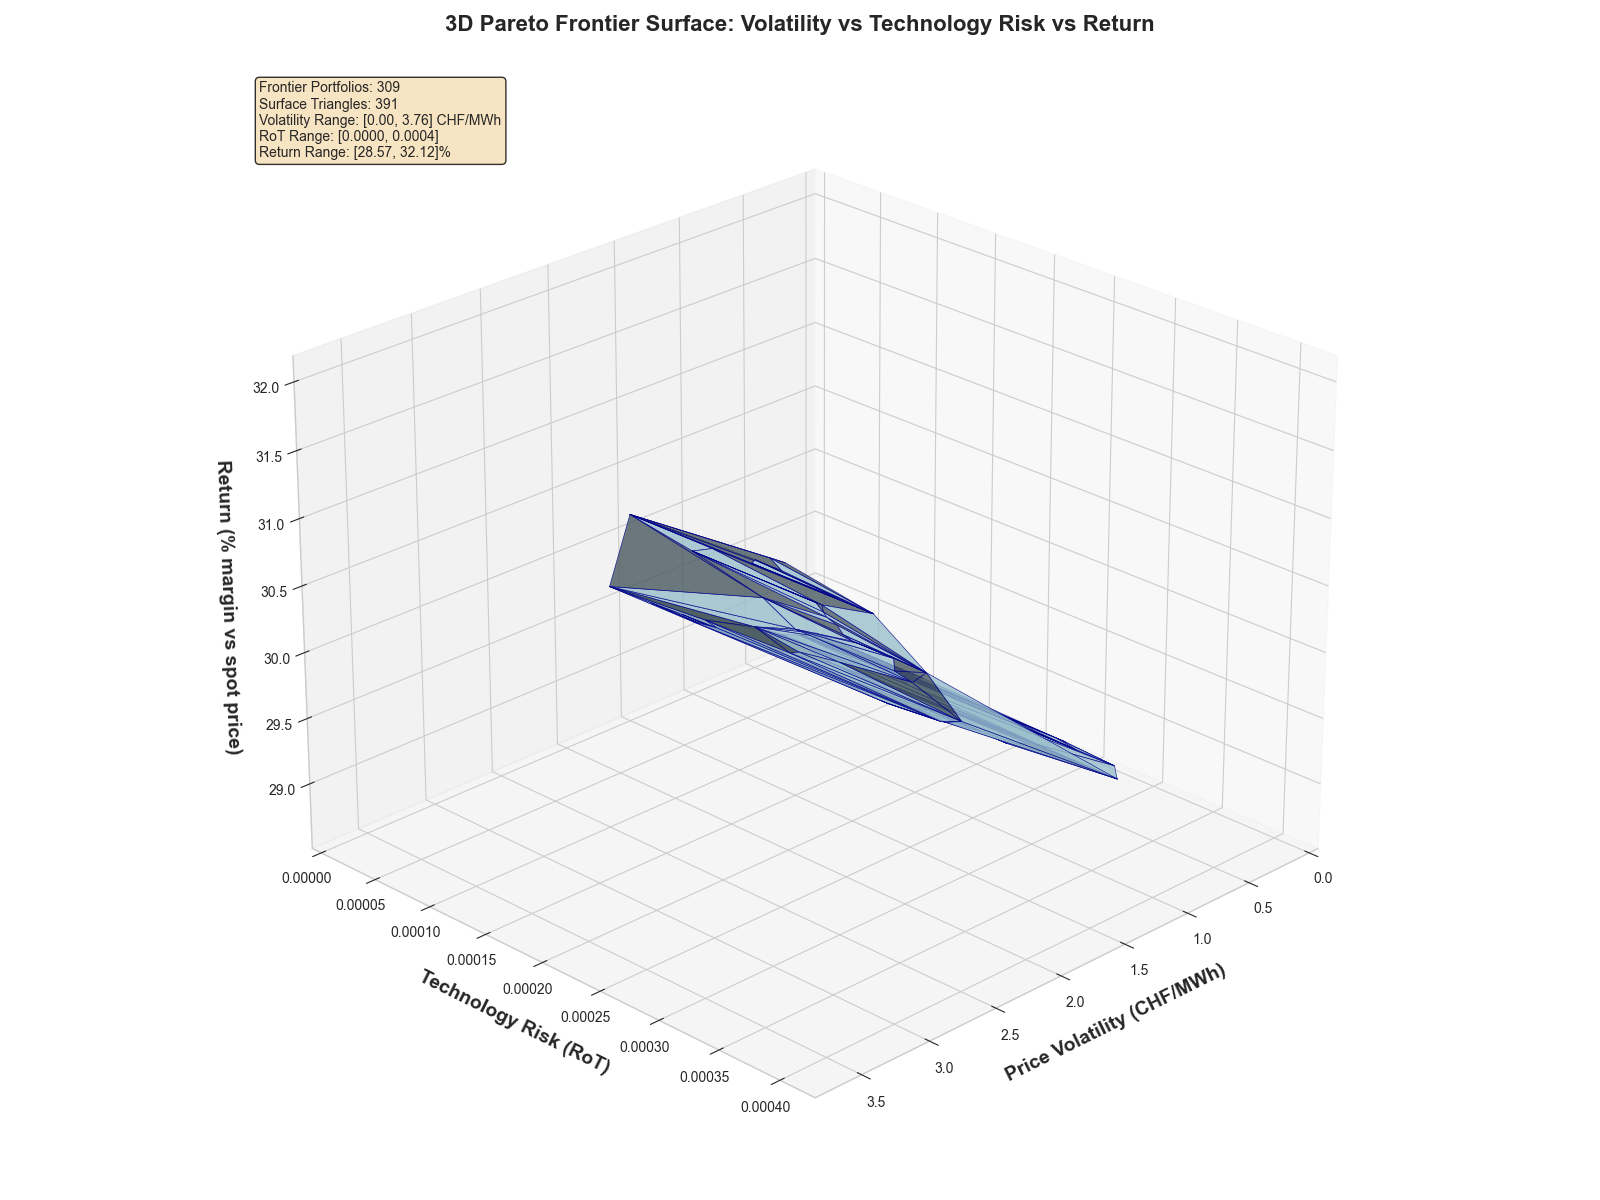

✅ 3D frontier surface plot saved to: data/result_plots/efficiency_frontier_3d_surface.png

EXTREME POINTS ON FRONTIER SURFACE

Lowest RoT:
  RoT: 0.0000
  Volatility: 0.13 CHF/MWh
  Return: 28.61%

Lowest Volatility:
  RoT: 0.0000
  Volatility: 0.00 CHF/MWh
  Return: 28.57%

Highest Return:
  RoT: 0.0004
  Volatility: 3.76 CHF/MWh
  Return: 32.12%


In [13]:
# ============================================================================
# 3D FRONTIER SURFACE VISUALIZATION (SURFACE/PLANE)
# ============================================================================
# Create a surface/plane from the frontier points for better interpretation
# Interactive: You can rotate and zoom the plot by clicking and dragging

# Enable interactive matplotlib widget for rotation/zooming
# Note: If interactive mode doesn't work, install: pip install ipympl
# Then restart the kernel and run this cell again
try:
    from IPython import get_ipython
    get_ipython().run_line_magic('matplotlib', 'widget')
    print("✅ Interactive mode enabled - click and drag to rotate, scroll to zoom")
except:
    try:
        from IPython import get_ipython
        get_ipython().run_line_magic('matplotlib', 'notebook')
        print("✅ Interactive mode enabled (notebook backend) - click and drag to rotate")
    except:
        print("⚠️  Using static backend - install ipympl for interactive plots: pip install ipympl")
        print("   You can still view the plot, but rotation requires interactive backend")
print()

# Define data file paths (persistent across kernel restarts)
frontier_3d_path = "data/result_plots/multi_objective_results_3d_frontier_3d.csv"
frontier_2d_path = "data/result_plots/multi_objective_results_frontier.csv"
all_data_3d_path = "data/result_plots/multi_objective_results_3d.csv"
all_data_2d_path = "data/result_plots/multi_objective_results.csv"

# Always load from files (works even after kernel restart)
# Prefer 3D frontier if available, else use 2D frontier
if os.path.exists(frontier_3d_path) and os.path.exists(all_data_3d_path):
    frontier_path = frontier_3d_path
    all_data_path = all_data_3d_path
    print(f"📂 Loading 3D frontier data from: {frontier_3d_path}")
elif os.path.exists(frontier_2d_path) and os.path.exists(all_data_2d_path):
    frontier_path = frontier_2d_path
    all_data_path = all_data_2d_path
    print(f"📂 Loading 2D frontier data from: {frontier_2d_path}")
    print("   (Run '3D Pareto Frontier Exploration' cell for 3D frontier)")
else:
    raise FileNotFoundError(
        f"ERROR: No frontier data files found.\n"
        f"Please run one of these cells first:\n"
        f"  - 'Alternative: Multi-Objective Exploration' (creates 2D frontier)\n"
        f"  - '3D Pareto Frontier Exploration' (creates 3D frontier)\n"
        f"\nExpected files:\n"
        f"  - {frontier_3d_path}\n"
        f"  - {frontier_2d_path}"
    )

# Load data from CSV files (persists across kernel restarts)
pareto_df = pd.read_csv(frontier_path)
all_df = pd.read_csv(all_data_path)
print(f"✅ Loaded {len(pareto_df)} frontier portfolios from {len(all_df)} total portfolios")
print()

print("="*80)
print("3D FRONTIER SURFACE VISUALIZATION")
print("="*80)
print(f"Frontier portfolios: {len(pareto_df)}")
print()

# Convert to numpy arrays
x_surf = np.array(pareto_df['y_volatility'].values)   # X-axis: Volatility
y_surf = np.array(pareto_df['x_RoT'].values)          # Y-axis: Technology Risk (RoT)
z_surf = np.array(pareto_df['z_return'].values)       # Z-axis: Return/Margin

# Check if we have enough points for a surface (need at least 3)
if len(pareto_df) < 3:
    print("⚠️  Warning: Need at least 3 frontier points to create a surface.")
    print("   Showing scatter plot instead.")
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x_surf, y_surf, z_surf, c=z_surf, cmap='viridis', s=200)
    plt.colorbar(scatter, ax=ax, label='Return (%)')
    ax.set_xlabel('Volatility (CHF/MWh)')
    ax.set_ylabel('RoT')
    ax.set_zlabel('Return (%)')
    plt.show()
else:
    # Create smooth surface using plot_trisurf (smoother than manual triangulation)
    from scipy.spatial import Delaunay
    from matplotlib.colors import Normalize
    import matplotlib.cm as cm
    
    # Create Delaunay triangulation in 2D (X-Y plane)
    points_2d = np.column_stack([x_surf, y_surf])
    tri = Delaunay(points_2d)
    
    # Create figure
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # Use plot_trisurf for smoother surface with interpolation
    # Uniform color (no colormap) to better see the surface shape
    surface = ax.plot_trisurf(
        x_surf, y_surf, z_surf,
        triangles=tri.simplices,
        color='lightblue',  # Uniform color instead of colormap
        alpha=0.8,
        edgecolor='darkblue',
        linewidth=0.5,
        antialiased=True,
        shade=True
    )
    
    # Highlight extreme points (optional - can be removed if you want only surface)
    extreme_points = {
        'Lowest RoT': pareto_df.loc[pareto_df['x_RoT'].idxmin()],
        'Lowest Volatility': pareto_df.loc[pareto_df['y_volatility'].idxmin()],
        'Highest Return': pareto_df.loc[pareto_df['z_return'].idxmax()]
    }
    
    # Uncomment below if you want to keep extreme point markers
    # for label, point in extreme_points.items():
    #     ax.scatter(
    #         [point['y_volatility']],
    #         [point['x_RoT']],
    #         [point['z_return']],
    #         s=400,
    #         c='red',
    #         marker='*',
    #         edgecolors='black',
    #         linewidths=2,
    #         alpha=1.0,
    #         zorder=15,
    #         label=label
    #     )
    
    # Set axis limits to zoom in (minimal padding for tighter view)
    x_range = x_surf.max() - x_surf.min()
    y_range = y_surf.max() - y_surf.min()
    z_range = z_surf.max() - z_surf.min()
    # Reduced padding from 0.1 to 0.02 for closer zoom
    padding = 0.02
    ax.set_xlim((x_surf.min() - padding*x_range, x_surf.max() + padding*x_range))
    ax.set_ylim((y_surf.min() - padding*y_range, y_surf.max() + padding*y_range))
    ax.set_zlim((z_surf.min() - padding*z_range, z_surf.max() + padding*z_range))
    
    # No colorbar needed since we're using uniform color
    
    # Labels and title
    ax.set_xlabel('Price Volatility (CHF/MWh)', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_ylabel('Technology Risk (RoT)', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_zlabel('Return (% margin vs spot price)', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_title('3D Pareto Frontier Surface: Volatility vs Technology Risk vs Return', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Set viewing angle for better visualization
    ax.view_init(elev=25, azim=45)
    
    # Add legend
    ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
    
    # Add statistics text box
    stats_text = (
        f"Frontier Portfolios: {len(pareto_df)}\n"
        f"Surface Triangles: {len(tri.simplices)}\n"
        f"Volatility Range: [{pareto_df['y_volatility'].min():.2f}, {pareto_df['y_volatility'].max():.2f}] CHF/MWh\n"
        f"RoT Range: [{pareto_df['x_RoT'].min():.4f}, {pareto_df['x_RoT'].max():.4f}]\n"
        f"Return Range: [{pareto_df['z_return'].min():.2f}, {pareto_df['z_return'].max():.2f}]%"
    )
    
    ax.text2D(0.02, 0.98, stats_text,
              transform=ax.transAxes,
              fontsize=10,
              verticalalignment='top',
              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Save figure
    save_path_surface = 'data/result_plots/efficiency_frontier_3d_surface.png'
    fig.savefig(save_path_surface, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"✅ 3D frontier surface plot saved to: {save_path_surface}")

# Print extreme points
print()
print("="*80)
print("EXTREME POINTS ON FRONTIER SURFACE")
print("="*80)
for label, point in extreme_points.items():
    print(f"\n{label}:")
    print(f"  RoT: {point['x_RoT']:.4f}")
    print(f"  Volatility: {point['y_volatility']:.2f} CHF/MWh")
    print(f"  Return: {point['z_return']:.2f}%")
print("="*80)


In [ ]:
# ============================================================================
# ADDITIONAL ANALYSIS: Top Portfolios by Each Metric
# ============================================================================

print("="*60)
print("TOP PORTFOLIOS BY METRIC")
print("="*60)
print()

# Top 5 by Return (highest savings)
print("🏆 Top 5 Portfolios by Return (% savings):")
top_return = df_results.nlargest(5, 'z_return')[['x_RoT', 'y_volatility', 'z_return', 'portfolio_parsed']]
for idx, row in top_return.iterrows():
    print(f"  Return: {row['z_return']:.2f}% | RoT: {row['x_RoT']:.4f} | Volatility: {row['y_volatility']:.2f}")
    print(f"    Portfolio: {row['portfolio_parsed']}")
    print()

print()

# Top 5 by Low Risk (lowest RoT)
print("🛡️ Top 5 Portfolios by Low Risk (RoT):")
top_low_risk = df_results.nsmallest(5, 'x_RoT')[['x_RoT', 'y_volatility', 'z_return', 'portfolio_parsed']]
for idx, row in top_low_risk.iterrows():
    print(f"  RoT: {row['x_RoT']:.4f} | Return: {row['z_return']:.2f}% | Volatility: {row['y_volatility']:.2f}")
    print(f"    Portfolio: {row['portfolio_parsed']}")
    print()

print()

# Top 5 by Low Volatility
print("📊 Top 5 Portfolios by Low Volatility:")
top_low_vol = df_results.nsmallest(5, 'y_volatility')[['x_RoT', 'y_volatility', 'z_return', 'portfolio_parsed']]
for idx, row in top_low_vol.iterrows():
    print(f"  Volatility: {row['y_volatility']:.2f} | Return: {row['z_return']:.2f}% | RoT: {row['x_RoT']:.4f}")
    print(f"    Portfolio: {row['portfolio_parsed']}")
    print()


TOP PORTFOLIOS BY METRIC

🏆 Top 5 Portfolios by Return (% savings):
  Return: -56.52% | RoT: 0.0721 | Volatility: 67.29
    Portfolio: {'PV': 263, 'WD_ON': 277, 'WD_OFF': 338, 'HYD_R': 90, 'BIO_WOOD': 347, 'HYD_S': 14, 'THERM': 894, 'H2P_G': 680, 'H2P_L': 989, 'SOL_SALT': 48, 'SOL_STEAM': 9, 'BIO_OIL_ICE': 336, 'PALM_ICE': 477, 'IMP_BIOG': 535, 'THERM_CH4': 565, 'NH3_P': 973, 'PHS': 950, 'H2_G': 853, 'H2_GL': 519, 'H2_L': 487, 'SYN_FT': 833, 'SYN_METH': 814, 'NH3_FULL': 896, 'SYN_CRACK': 348, 'CH4_BIO': 870, 'SOL_SALT_STORE': 33}

  Return: -232.52% | RoT: 0.1722 | Volatility: 185.57
    Portfolio: {'PV': 247, 'WD_ON': 720, 'WD_OFF': 20, 'HYD_R': 92, 'BIO_WOOD': 554, 'HYD_S': 10, 'THERM': 796, 'H2P_G': 878, 'H2P_L': 768, 'SOL_SALT': 138, 'SOL_STEAM': 35, 'BIO_OIL_ICE': 301, 'PALM_ICE': 537, 'IMP_BIOG': 43, 'THERM_CH4': 598, 'NH3_P': 178, 'PHS': 67, 'H2_G': 455, 'H2_GL': 927, 'H2_L': 116, 'SYN_FT': 991, 'SYN_METH': 45, 'NH3_FULL': 944, 'SYN_CRACK': 847, 'CH4_BIO': 538, 'SOL_SALT_STORE':

---

## Conclusion

This notebook demonstrates a complete optimization pipeline for Swiss energy portfolio planning:

1. **Data-driven approach**: Uses 2024 hourly data for demand, renewables, and spot prices
2. **Energy sovereignty**: Ensures the portfolio can produce ≥113 TWh/year
3. **Robust evaluation**: Tests each portfolio across multiple random scenarios
4. **Sophisticated dispatch**: Implements storage management with disposition indices
5. **Genetic optimization**: Efficiently explores the solution space
6. **Full year validation**: Tests the optimized portfolio across the entire year

The optimal portfolio balances renewable sources (solar, wind) with storage capabilities and flexible generation to meet Switzerland's energy needs reliably and cost-effectively.
